# Food Demand Forecast

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.
 

**Data Dictionary**
1.	Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable 

Variable|Definition
:-------|:---------
id      | Unique ID
week	| Week No
center_id|Unique ID for fulfillment center
meal_id	  | Unique ID for Meal
checkout_price|Final price including discount, taxes & delivery charges
base_price	   | Base price of the meal
emailer_for_promotion|	Emailer sent for promotion of meal
homepage_featured	  |  Meal featured at homepage
num_orders	           | (Target) Orders Count

2.	fulfilment_center_info.csv: Contains information for each fulfilment center

Variable	|    Definition
:---------|:---------
center_id	|    Unique ID for fulfillment center
city_code	 |   Unique code for city
region_code	  |  Unique code for region
center_type	  |  Anonymized center type
op_area	      |  Area of operation (in km^2)
 
3.	meal_info.csv: Contains information for each meal being served

Variable	|    Definition
:---------|:---------
meal_id	  |      Unique ID for the meal
category	|    Type of meal (beverages/snacks/soups….)
cuisine	    |    Meal cuisine (Indian/Italian/…)



In [241]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [242]:
# loading the datasets
weekly_demand = pd.read_csv('training_dataset/train.csv')
fullfil_centers = pd.read_csv('training_dataset/fulfilment_center_info.csv')
meal_info = pd.read_csv('training_dataset/meal_info.csv')
test = pd.read_csv('test_dataset/test_QoiMO9B.csv')

In [243]:
# Displaying the first few rows of the weekly demand dataset to understand its structure
weekly_demand.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [244]:
# Checking the data types and non-null counts in the weekly demand dataset
weekly_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [245]:
# Generating summary statistics for numerical columns in the weekly demand dataset
weekly_demand.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00


In [246]:
# checking for null values in weekly demand dataset
weekly_demand.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [247]:
fullfil_centers.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [248]:
# Checking the data types and non-null counts in the fulfillment centers dataset
fullfil_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [249]:
# Generating summary statistics for numerical columns in the weekly demand dataset
fullfil_centers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
center_id,77.0,83.142857,46.090219,10.0,50.0,77.0,110.0,186.0
city_code,77.0,600.662338,66.720274,456.0,553.0,596.0,651.0,713.0
region_code,77.0,56.493506,18.126473,23.0,34.0,56.0,77.0,93.0
op_area,77.0,3.985714,1.106406,0.9,3.5,3.9,4.4,7.0


In [250]:
# Checking for missing values in the fullfilment canter dataset
fullfil_centers.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [251]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [252]:
# Checking the data types and non-null counts in the meal info dataset
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [253]:
# checking for null values in meal info dataset
meal_info.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [254]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [255]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [256]:
# Generating summary statistics for numerical columns in the test dataset
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00


In [257]:
# checking for null values in test dataset
test.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [258]:
# Adding a placeholder column for predictions in the test dataset
test['num_orders'] = 0

In [259]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,0
1,1127204,146,55,1993,160.11,159.11,0,0,0
2,1212707,146,55,2539,157.14,159.14,0,0,0
3,1082698,146,55,2631,162.02,162.02,0,0,0
4,1400926,146,55,1248,163.93,163.93,0,0,0


In [260]:
# merging all the data sets into single datset for analysis
data = pd.concat([weekly_demand, test], axis=0)
data = data.merge(fullfil_centers, on='center_id', how='left')
data = data.merge(meal_info, on='meal_id', how='left')
data.shape

(489121, 15)

In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             489121 non-null  int64  
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [262]:
data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

The null values in num_order column are equal to the number of rows in the test dataset (containing data from week 146-155) loaded earlier. These rows will be left out of the analysis since we want to predict the demand for the next 10-week period with the help of a prediction model.

# Feature Engineering


In [263]:
# Creating a new feature for discount amount
data['discount_amount']=data['base_price']-data['checkout_price']

In [264]:
# Creating a new feature for discount percentage
data['discount_percent'] = ((data['base_price']-data['checkout_price'])/data['base_price'])*100

In [265]:
# Creating a binary feature to indicate whether a discount was applied
data['discount y/n'] = [1 if x>0 else 0 for x in (data['base_price']-data['checkout_price'])]

In [266]:
# Creating a feature to compare the change in weekly prices
data['weekly_base_price_change'] = data.groupby(['meal_id', 'center_id'])['base_price'].diff()

# Fill NaN values (e.g., for the first week) with 0
data['weekly_base_price_change'] = data['weekly_base_price_change'].fillna(0)

In [267]:
# Creating feature that calculates weekly changes in checkout price
data['weekly_checkout_price_change'] = data.groupby(['meal_id', 'center_id'])['checkout_price'].diff()

# Fill NaN values (e.g., for the first week) with 0
data['weekly_checkout_price_change'] = data['weekly_checkout_price_change'].fillna(0)

In [268]:
# Extract week of the year
data['week_of_year'] = data['week'].apply(lambda x: x % 52 if x % 52 != 0 else 52)

In [269]:
# Extract quarter of the year
data['quarter'] = data['week_of_year'].apply(lambda x: (x - 1) // 13 + 1)

In [270]:
# Counting the number of occurrences of each quarter
data['quarter'].value_counts()

quarter
3    124373
2    122513
4    121634
1    120601
Name: count, dtype: int64

In [271]:
# Calculating 4-week rolling average for checkout_price and base_price
data['4_week_avg_checkout_price'] = data.groupby(['meal_id', 'center_id'])['checkout_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
data['4_week_avg_base_price'] = data.groupby(['meal_id', 'center_id'])['base_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

In [272]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,cuisine,discount_amount,discount_percent,discount y/n,weekly_base_price_change,weekly_checkout_price_change,week_of_year,quarter,4_week_avg_checkout_price,4_week_avg_base_price
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,Thai,15.46,10.151684,1,0.0,0.0,1,1,136.83,152.29
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,...,Thai,-1.00,-0.736214,0,0.0,0.0,1,1,136.83,135.83
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,...,Thai,1.00,0.736052,1,0.0,0.0,1,1,134.86,135.86
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,...,Indian,98.03,22.405321,1,0.0,0.0,1,1,339.50,437.53
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,...,Indian,-1.00,-0.412371,0,0.0,0.0,1,1,243.50,242.50


In [273]:
data.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
dtype: int64

In [274]:
# Filtering the dataset to include only data from weeks 1 to 145 for further analysis
datax = data[data['week'].isin(range(1,146))]

In [275]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456548 entries, 0 to 456547
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            456548 non-null  int64  
 1   week                          456548 non-null  int64  
 2   center_id                     456548 non-null  int64  
 3   meal_id                       456548 non-null  int64  
 4   checkout_price                456548 non-null  float64
 5   base_price                    456548 non-null  float64
 6   emailer_for_promotion         456548 non-null  int64  
 7   homepage_featured             456548 non-null  int64  
 8   num_orders                    456548 non-null  int64  
 9   city_code                     456548 non-null  int64  
 10  region_code                   456548 non-null  int64  
 11  center_type                   456548 non-null  object 
 12  op_area                       456548 non-null  fl

Using data from week 1 to week 145 for further analysis.

# Exploratory Data Analysis (EDA)

<Axes: >

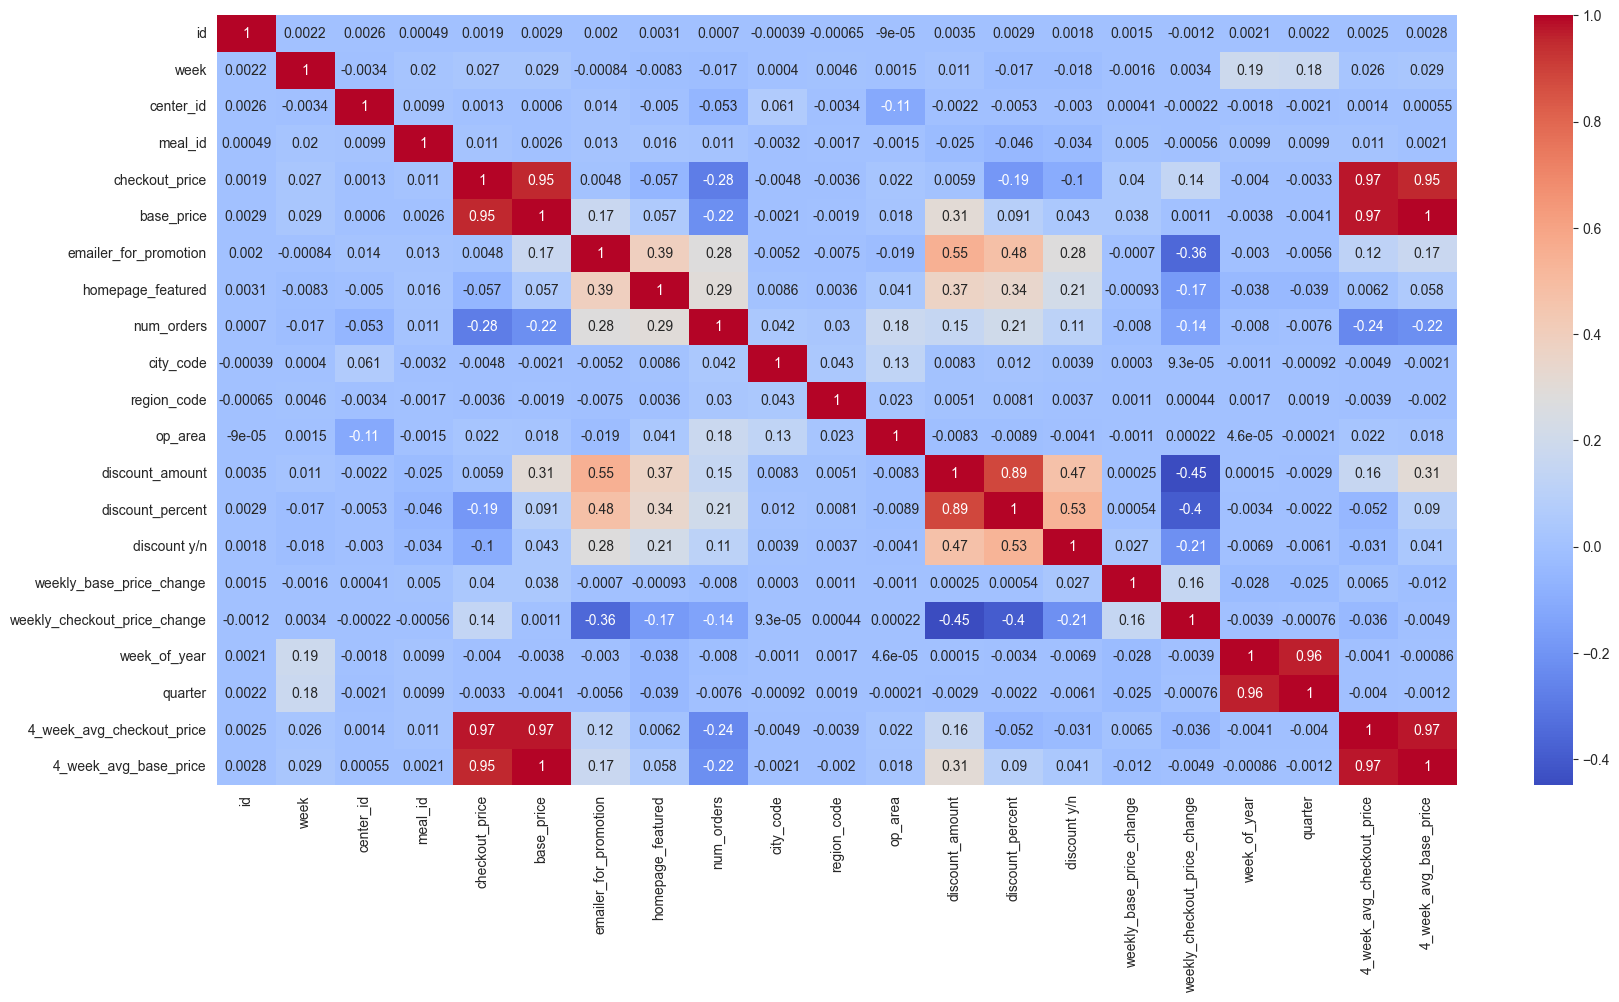

In [276]:
# Visualizing correlations between numerical features using a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(datax.corr(numeric_only=True), annot=True, cmap='coolwarm')

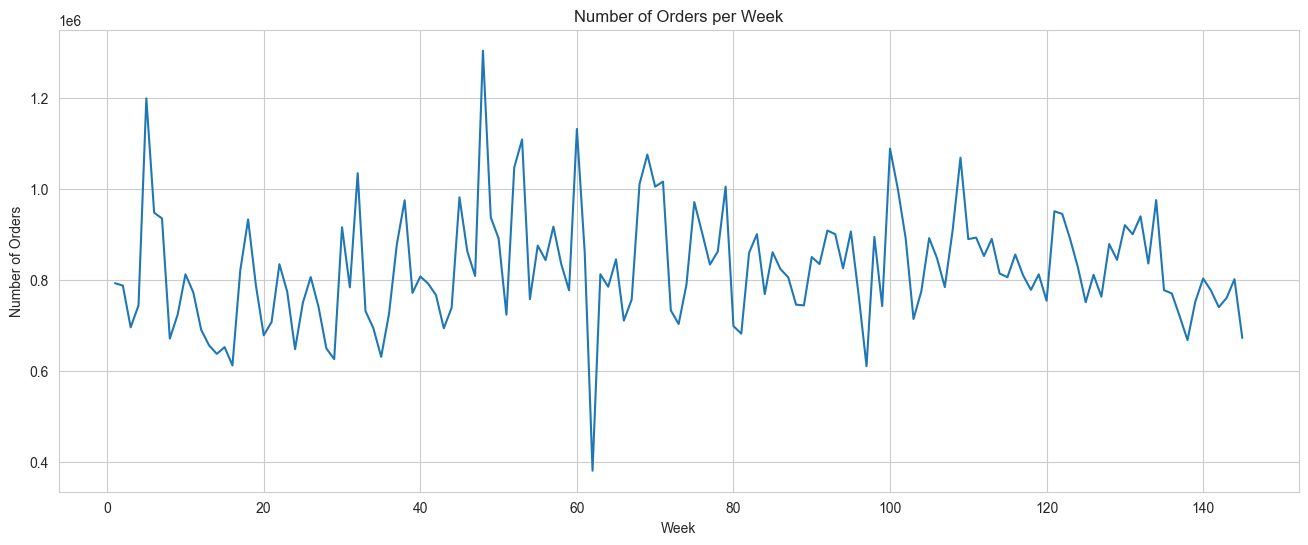

In [277]:
# Visualizing the trend of the number of orders per week
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='num_orders', data=datax,estimator='sum',errorbar=None)
plt.title('Number of Orders per Week')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.show()

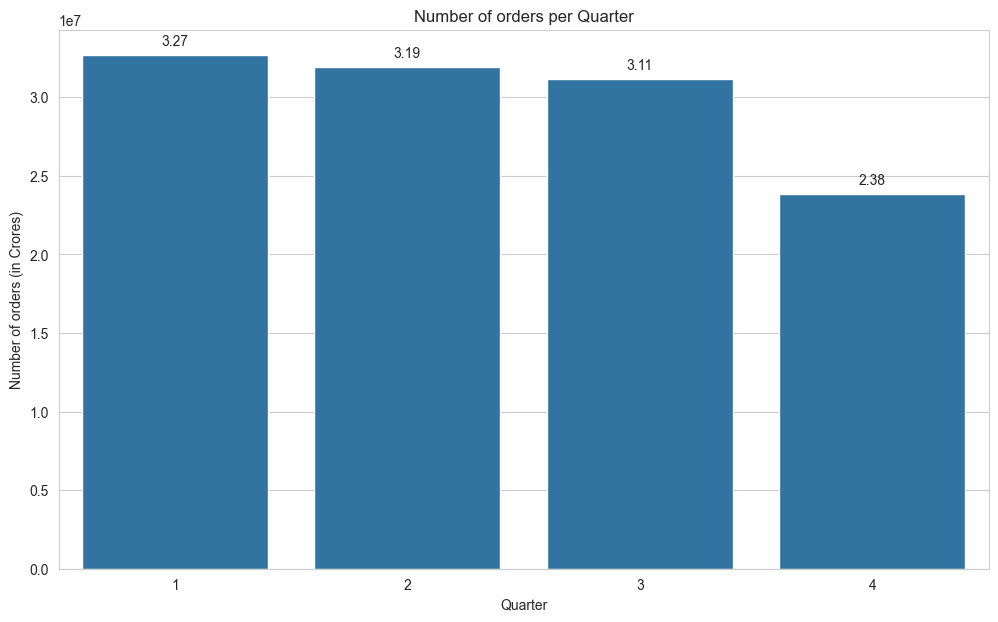

In [278]:
# Visualizing the trend of the number of orders per quarter
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='quarter', y='num_orders', data=datax, estimator='sum', errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Quarter')
plt.title('Number of orders per Quarter')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


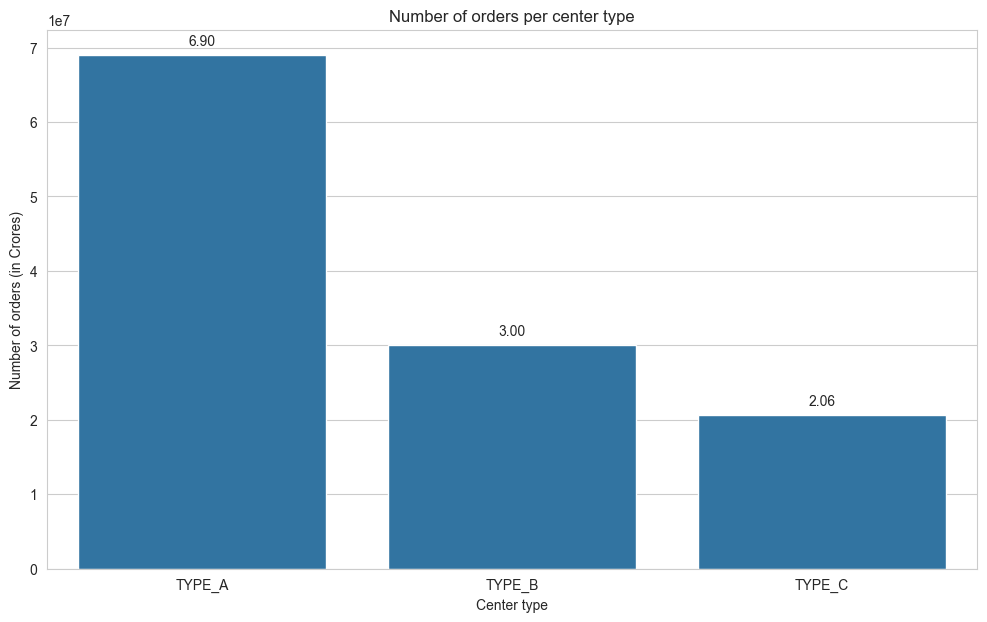

In [279]:
# Display total number of orders for each Center type
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='center_type', y='num_orders', data=datax.groupby('center_type').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Center type')
plt.title('Number of orders per center type')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


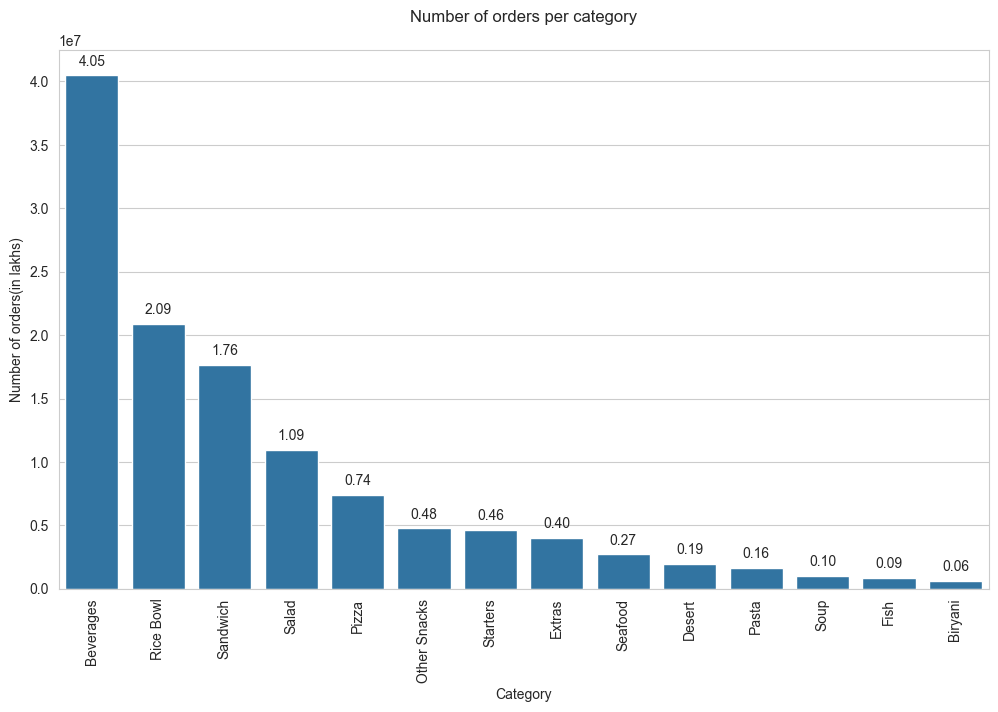

In [280]:
# Display total number of orders for each meal category
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))
a2 = sns.barplot(x='category', y='num_orders', data=datax.groupby('category').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders(in lakhs)')
plt.xlabel('Category')
plt.title('Number of orders per category',pad=20)
plt.xticks(rotation=90)

# display data labels on bars
for p in a2.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a2.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

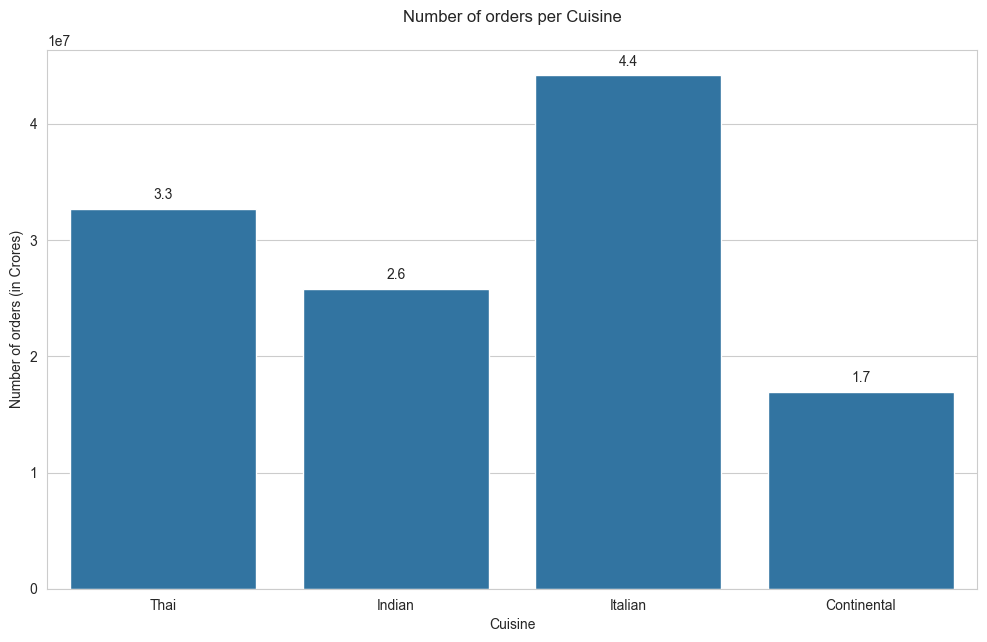

In [281]:
# Visualizing the total number of orders for each cuisine type    
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))  # Adjust the width and height as needed
a3 = sns.barplot(x='cuisine', y='num_orders', data=datax,estimator=sum,errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Cuisine')
plt.title('Number of orders per Cuisine', pad=20)

# Display data labels on bars
for p in a3.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a3.annotate(format(value_in_crores, '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# plt.xticks(rotation=90)
# plt.show()

Text(0.5, 1.0, 'Total Number of Orders for Each Category')

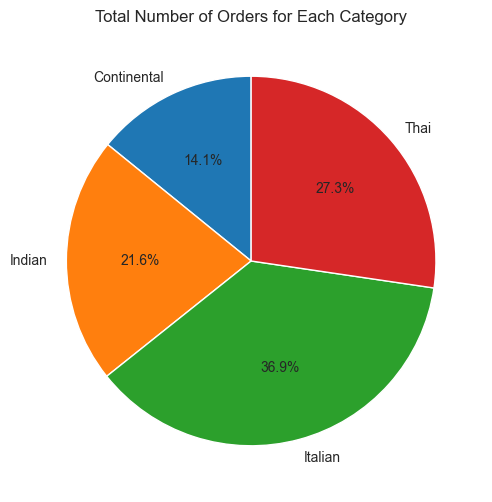

In [282]:
# A pie chart to visualize the total number of orders for each cuisine type.
plt.figure(figsize=(6,6))
plt.pie(datax.groupby(['cuisine']).num_orders.sum(),
    labels=datax.groupby(['cuisine']).num_orders.sum().index,
    startangle=90,
    autopct='%1.1f%%',pctdistance=0.6,)
plt.title('Total Number of Orders for Each Category')

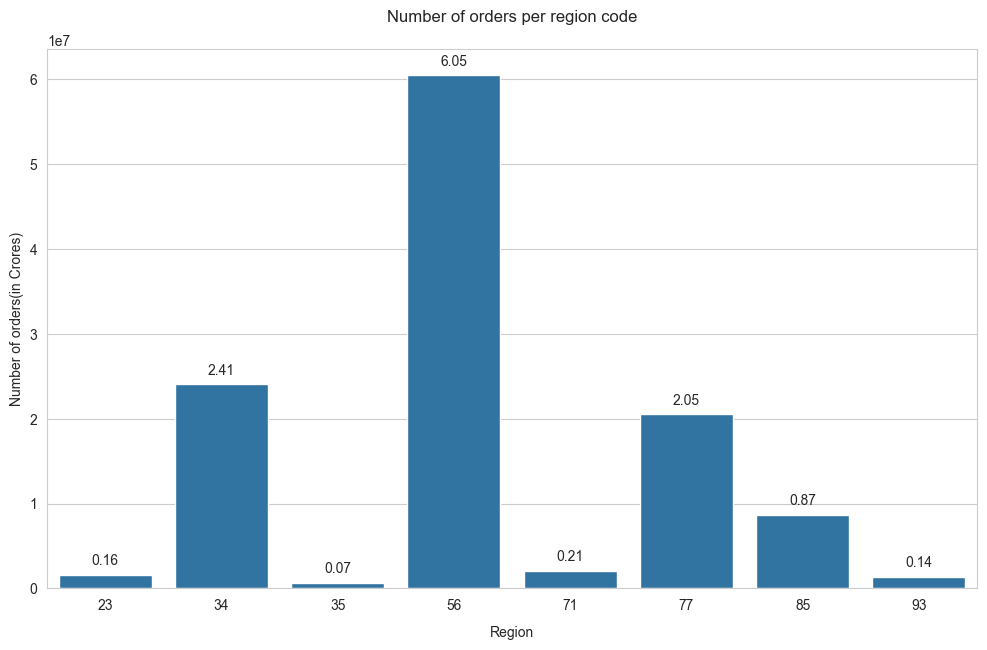

In [283]:
# Display total number of orders for each region code.
plt.figure(figsize=(12, 7))
a4 = sns.barplot(x='region_code',y='num_orders',data=datax,estimator=sum,errorbar=None)
                 
plt.ylabel('Number of orders(in Crores)')
plt.xlabel('Region',labelpad=10)
plt.title('Number of orders per region code',pad=20)
for p in a4.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a4.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center', xytext = (0, 10),
                  textcoords = 'offset points')
plt.show()

Text(0.5, 0, 'City')

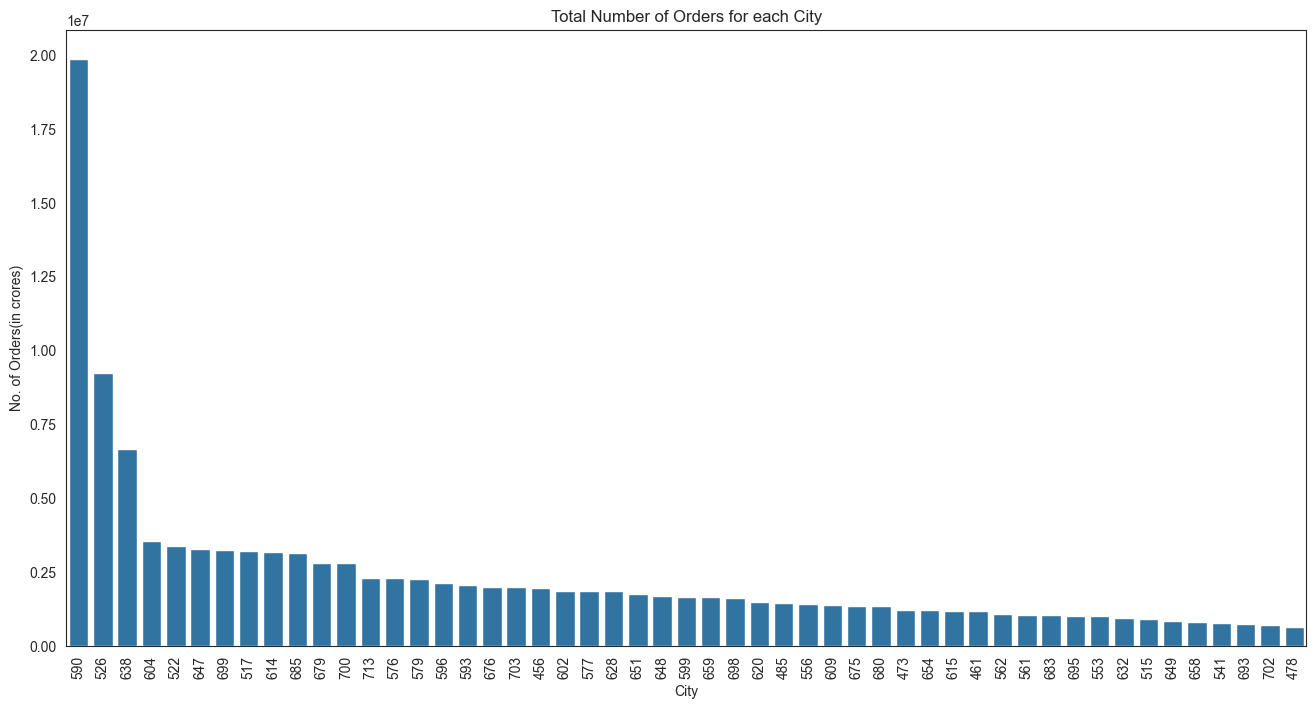

In [284]:
# Visualizing the trend of the number of orders for each city.
fig=plt.figure(figsize=(16,8))
sns.set_style("white")
plt.xticks(rotation=90)
plt.title('Total Number of Orders for each City')
a5 = sns.barplot(y='num_orders', x='city_code', data=datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index(),
            order=list(datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index()['city_code'].values))
plt.ylabel('No. of Orders(in crores)')
plt.xlabel('City')

As per our observation from our barchart of the City against the number of orders. There the high significant difference between the Top 3 cities(590,526,638) which have the highest number of orders. Therefore, we will categorize the City with Highest No. of Orders as C1, City with 2nd Highest No. of Orders as C2 and City with 3rd Highest No. of Orders as C3 and the remaining cities will be categorized as CH4, since, they do not have much significant differences between the number of orders.

In [285]:
# Categorizing cities into four groups based on their order volume.
city4={590:'C1', 526:'C2', 638:'C3'}
data['city_cat']=data['city_code'].map(city4)
data['city_cat']=data['city_cat'].fillna('C4')

In [286]:
data['city_cat'].value_counts()

city_cat
C4    362341
C1     58708
C2     46589
C3     21483
Name: count, dtype: int64

In [287]:
from sklearn.preprocessing import OneHotEncoder

In [288]:
# Select categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns

Index(['center_type', 'category', 'cuisine', 'city_cat'], dtype='object')

In [369]:
# Split data into train and test before encoding
train_df = data[data['week'].isin(range(1,136))] #for training the model
test_df = data[data['week'].isin(range(136,146))] #for testing the model
last_10week_df = data[data['week'].isin(range(146,156))] # for predicitions

In [370]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Fit the encoder on the *training* data
encoder.fit(train_df[categorical_columns])

# Transform both train and test data
train_encoded_data = encoder.transform(train_df[categorical_columns])
test_encoded_data = encoder.transform(test_df[categorical_columns])
last_10week_encoded_data = encoder.transform(last_10week_df[categorical_columns])

# Convert the encoded data to a DataFrame
train_encoded_df = pd.DataFrame(train_encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=train_df.index) # Preserve index
test_encoded_df = pd.DataFrame(test_encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=test_df.index) # Preserve index
last_10week_encoded_df = pd.DataFrame(last_10week_encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=last_10week_df.index) # Preserve index

# Drop the original categorical columns
train_df = train_df.drop(columns=categorical_columns)
test_df = test_df.drop(columns=categorical_columns)
last_10week_df = last_10week_df.drop(columns=categorical_columns)

# Concatenate the encoded columns with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)
last_10week_df = pd.concat([last_10week_df, last_10week_encoded_df], axis=1)

In [371]:
# importing standardscaler for scaling the train and test dataset
from sklearn.preprocessing import StandardScaler

In [372]:
# initializing StandardScaler
scaler = StandardScaler()

# using fit_transform and transform on train_df and test_df respectively.
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df) 
last_10week_df_scaled = scaler.transform(last_10week_df)

# converting the scaled data into a dataframe
train_df = pd.DataFrame(train_df_scaled, columns = train_df.columns,index=train_df.index)
test_df = pd.DataFrame(test_df_scaled, columns = test_df.columns,index=test_df.index)
last_10week_df = pd.DataFrame(last_10week_df_scaled, columns = last_10week_df.columns, index=last_10week_df.index)



In [373]:
# Prepare X_train, y_train, X_test, y_test
X_train = train_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True) 
y_train = train_df['num_orders'].reset_index(drop=True)
X_test = test_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True)
y_test = test_df['num_orders'].reset_index(drop=True)

# Display the updated DataFrames
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



X_train shape: (423727, 40)
X_test shape: (32821, 40)


# Model 1 - Linear Regression

In [299]:
# importing the libraries for model building
from sklearn.linear_model import LinearRegression

In [300]:
# Initializing the Linear Regression model
lm = LinearRegression()

In [301]:
# Fitting the model on the training data
lm.fit(X_train, y_train)

LinearRegression()

In [302]:
# Predicting on the test data
lm_predictions = lm.predict(X_test)

In [303]:
from sklearn import metrics

In [304]:
# Evaluating the model performance.
mae = metrics.mean_absolute_error(y_test,lm_predictions)
mse = metrics.mean_squared_error(y_test, lm_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lm_predictions))
r2 = metrics.r2_score(y_test, lm_predictions)
print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)


Mae: 0.36289021225563123
Mse: 0.2769151299912724
Rmse:  0.5262272607830882
R2: 0.41047063010701434


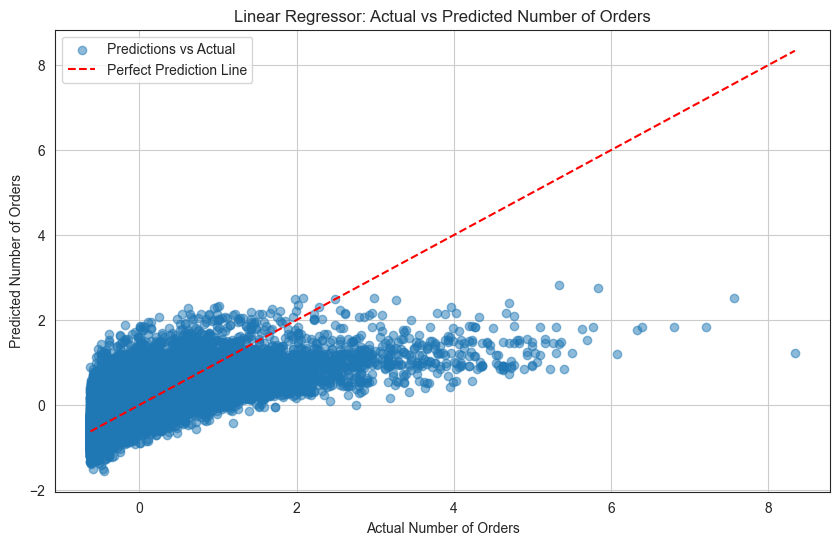

In [305]:
# Plotting Linear Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lm_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Linear Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 2: Ridge Regrssion

In [306]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [307]:
# Initializing the Ridge Regression model
ridge = Ridge()
# Setting up the parameter grid for alpha values
param_grid = {'alpha': np.logspace(-5, 5, 50)}
# Performing Grid Search with Cross-Validation
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
# Fitting the model on the training data
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e-02, 7....
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
             scoring='neg_mean_squared_error')

In [308]:
# Making predicting with ridge regression on the test data
ridge_predictions = ridge_cv.predict(X_test)

In [309]:
# Evaluating the model performance
mae = metrics.mean_absolute_error(y_test,ridge_predictions)
mse = metrics.mean_squared_error(y_test, ridge_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, ridge_predictions))
r2 = metrics.r2_score(y_test, ridge_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.3620639828716535
Mse: 0.27634694101325286
Rmse:  0.5256871132273007
R2: 0.41168025736791025


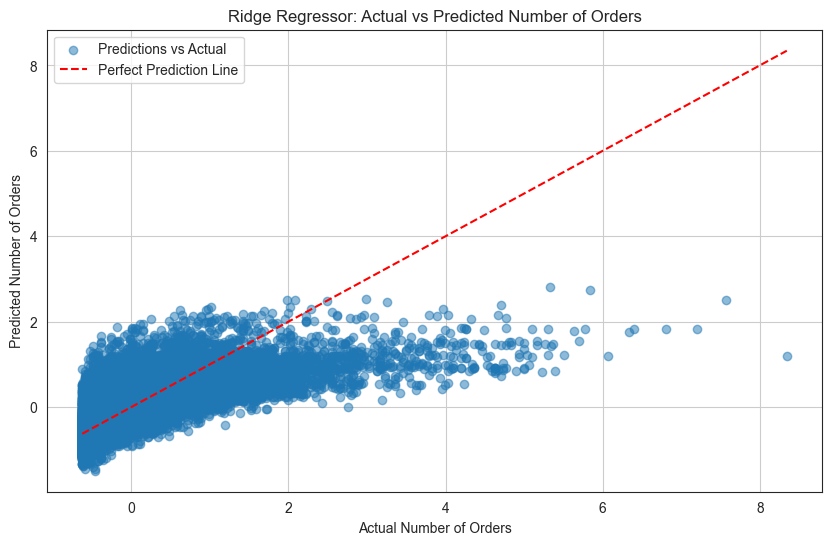

In [310]:
# Plotting Ridge Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Ridge Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 3: Lasso Regression

In [311]:
from sklearn.linear_model import Lasso

In [312]:
# Initializing the Lasso Regression model
lasso = Lasso()
# Setting up the parameter grid for alpha values
param_grid = {'alpha': np.logspace(-5, 3, 50)}
# Performing Grid Search with Cross-Validation
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# Fitting the model on the training data
lasso_cv.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.378e+04, tolerance: 3.232e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.330e+04, tolerance: 3.375e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.45634848e-05, 2.12095089e-05, 3.08884360e-05,
       4.49843267e-05, 6.55128557e-05, 9.54095476e-05, 1.38949549e-04,
       2.02358965e-04, 2.94705170e-04, 4.29193426e-04, 6.25055193e-04,
       9.10298178e-04, 1.32571137e-03, 1.93069773e-03, 2.81176870e-03,
       4.09491506e-03, 5.96362332e-03, 8.68511374e-03, 1....
       3.72759372e-01, 5.42867544e-01, 7.90604321e-01, 1.15139540e+00,
       1.67683294e+00, 2.44205309e+00, 3.55648031e+00, 5.17947468e+00,
       7.54312006e+00, 1.09854114e+01, 1.59985872e+01, 2.32995181e+01,
       3.39322177e+01, 4.94171336e+01, 7.19685673e+01, 1.04811313e+02,
       1.52641797e+02, 2.22299648e+02, 3.23745754e+02, 4.71486636e+02,
       6.86648845e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [313]:
# Making predictions with lasso regression on the test data
lasso_predictions = lasso_cv.predict(X_test)

In [314]:
# Evaluating the model performance
mae = metrics.mean_absolute_error(y_test,lasso_predictions)
mse = metrics.mean_squared_error(y_test, lasso_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso_predictions))
r2 = metrics.r2_score(y_test, lasso_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.3606623422413895
Mse: 0.27558393849994134
Rmse:  0.5249608923528888
R2: 0.41330462650553557


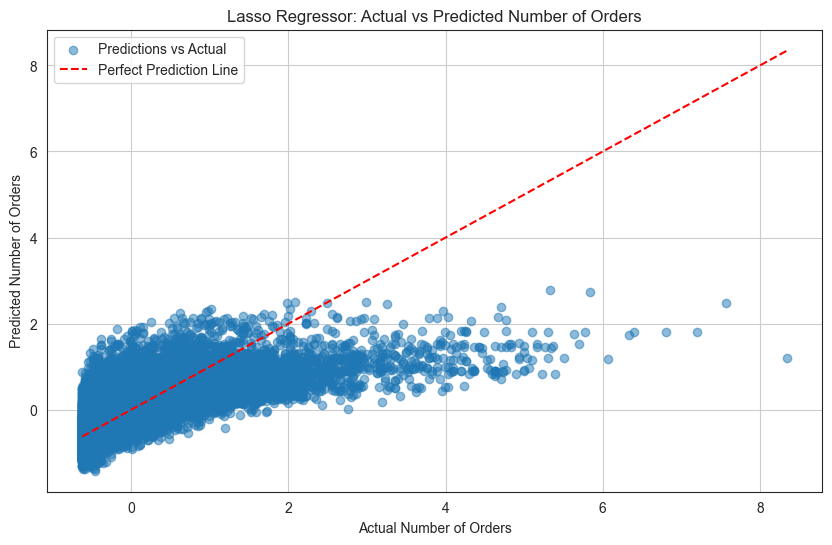

In [315]:
# Plotting Lasso Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lasso_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Lasso Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 3: Decision Tree

In [316]:
from sklearn.tree import DecisionTreeRegressor

In [317]:
# Initializing the Decision tree Regressor model
dtree = DecisionTreeRegressor(max_depth=100,random_state=42)

In [318]:
# Fitting the model on the training data
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100, random_state=42)

In [319]:
# Making predictions with decision tree regressor on the test data
dtree_predictions = dtree.predict(X_test)

In [320]:
# Evaluating the model performance
mae = metrics.mean_absolute_error(y_test,dtree_predictions)
mse = metrics.mean_squared_error(y_test, dtree_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, dtree_predictions))
r2 = metrics.r2_score(y_test, dtree_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.25126179486118233
Mse: 0.20229204620472624
Rmse:  0.4497688808763077
R2: 0.5693369931170115


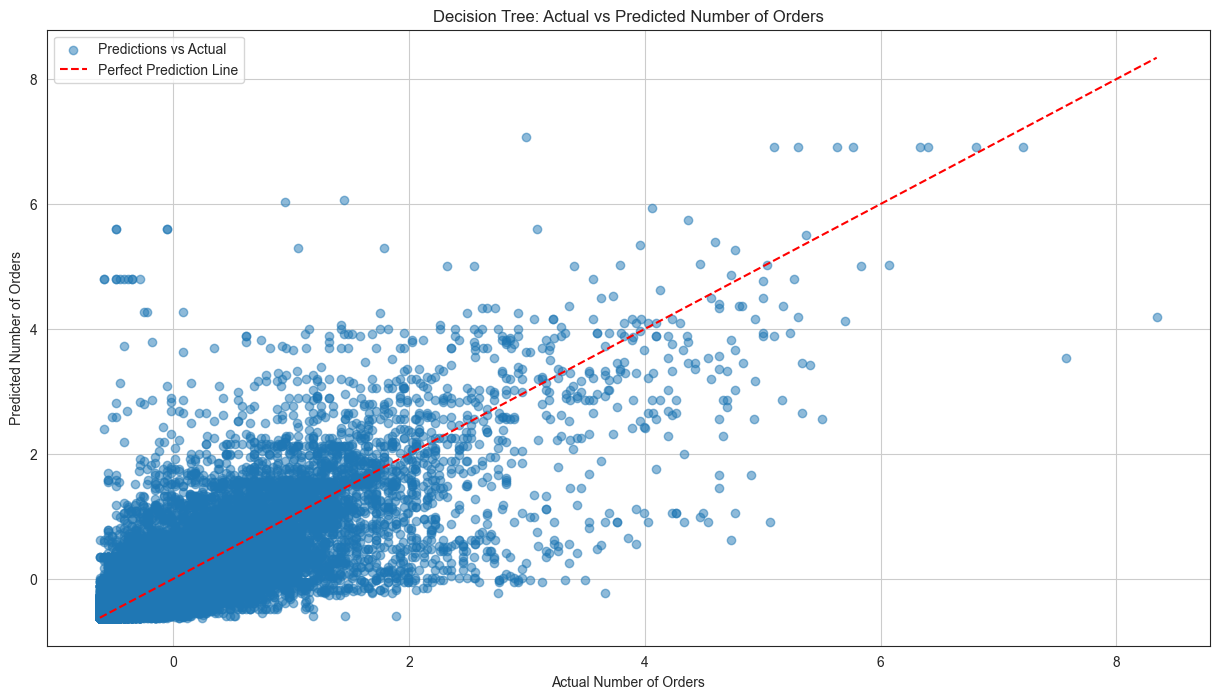

In [321]:
# Plotting Decision Tree predictions vs Actual values
plt.figure(figsize=(15, 8))
plt.scatter(y_test, dtree_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Decision Tree: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 4: Random Forest

In [322]:
from sklearn.ensemble import RandomForestRegressor

In [323]:
rfr = RandomForestRegressor(n_estimators=100,random_state=42,oob_score=True)

In [324]:
rfr.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [325]:
rfr_predictions = rfr.predict(X_test)

In [326]:
mae = metrics.mean_absolute_error(y_test,rfr_predictions)
mse = metrics.mean_squared_error(y_test, rfr_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, rfr_predictions))
r2 = metrics.r2_score(y_test, rfr_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.18375496312839262
Mse: 0.10789863097205098
Rmse:  0.3284792702318534
R2: 0.7702927538438445


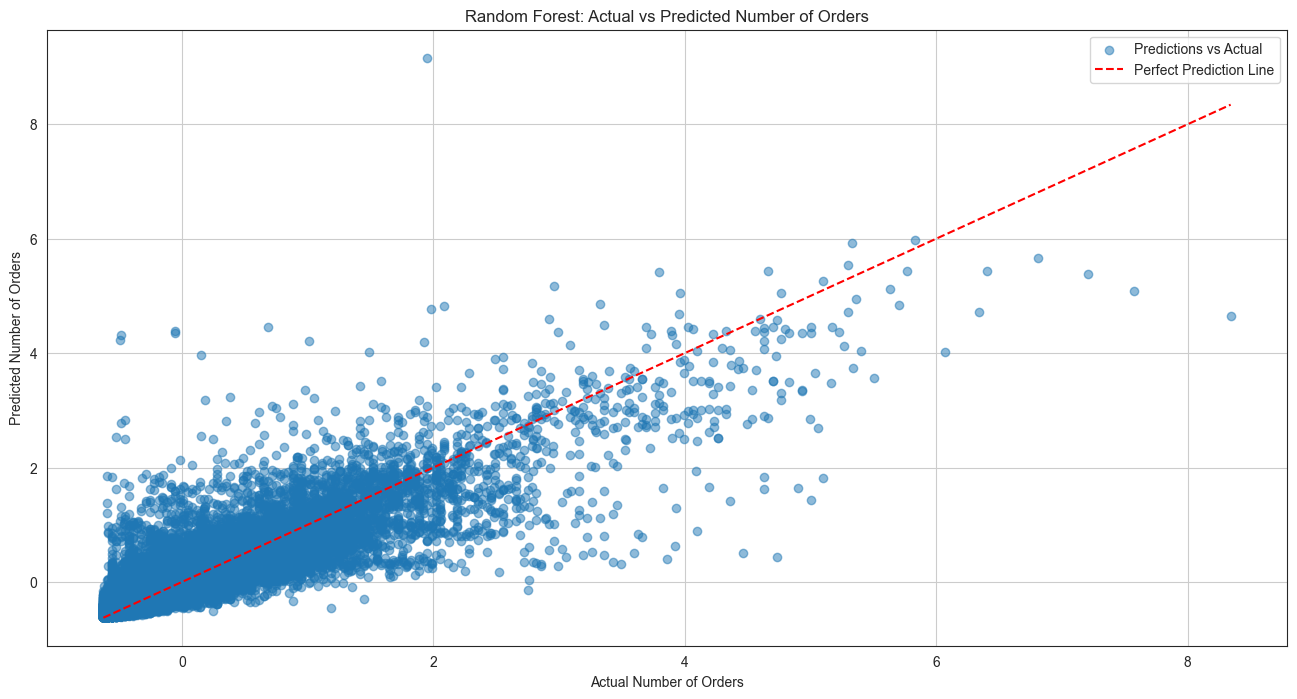

In [327]:
# Plotting Random Forest predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, rfr_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Random Forest: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 5: XGBoost

In [328]:
import xgboost as xgb

In [329]:
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,random_state=42)

In [330]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [331]:
xgb_predictions = xgb_regressor.predict(X_test)

In [332]:
mse = metrics.mean_squared_error(y_test, xgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, xgb_predictions))
r2 = metrics.r2_score(y_test, xgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.18375496312839262
Mse: 0.12904900983905854
Rmse:  0.3592339207801214
R2: 0.725265349502096


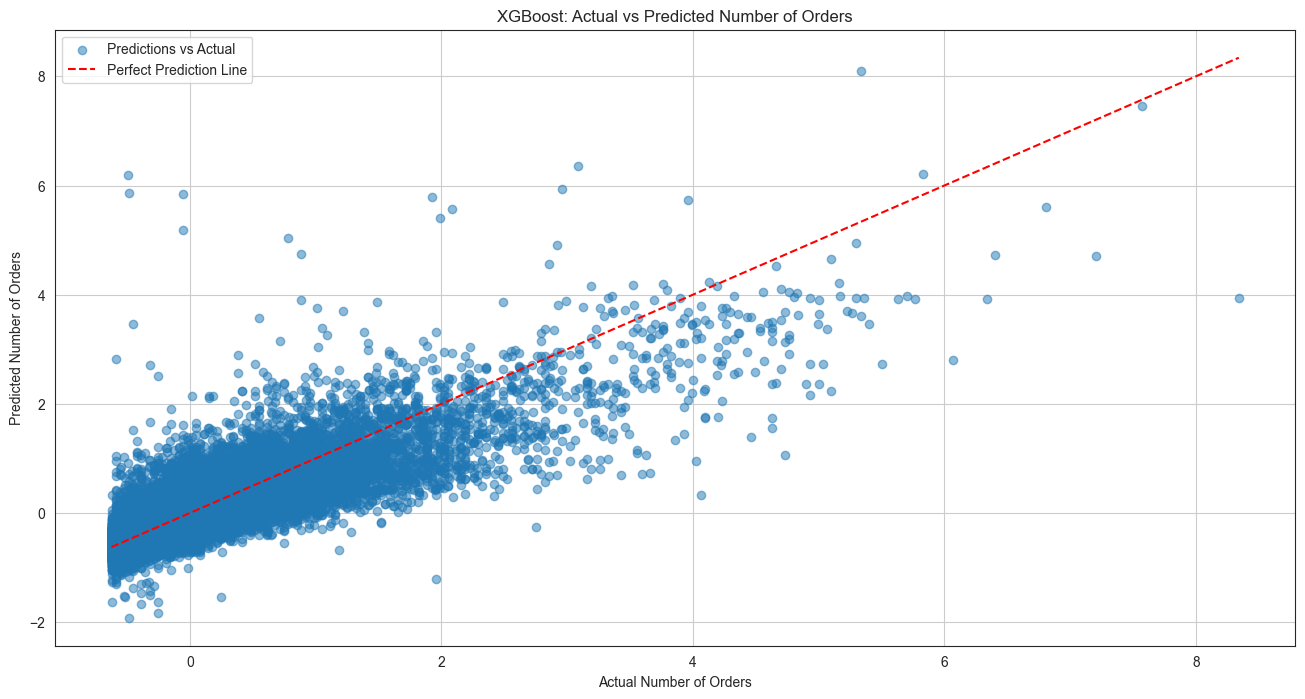

In [333]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, xgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('XGBoost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 6: light GBM

In [334]:
import lightgbm as lgb

In [335]:
lgb_regressor = lgb.LGBMRegressor(objective ='regression',metric = "rmse",n_estimators=100,random_state=42)

In [336]:
lgb_regressor.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 423727, number of used features: 40
[LightGBM] [Info] Start training from score 0.000000


LGBMRegressor(metric='rmse', objective='regression', random_state=42)

In [337]:
lgb_predictions = lgb_regressor.predict(X_test)

In [338]:
mse = metrics.mean_squared_error(y_test, lgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lgb_predictions))
r2 = metrics.r2_score(y_test, lgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.18375496312839262
Mse: 0.13169144682552378
Rmse:  0.36289316172328706
R2: 0.7196398200784713


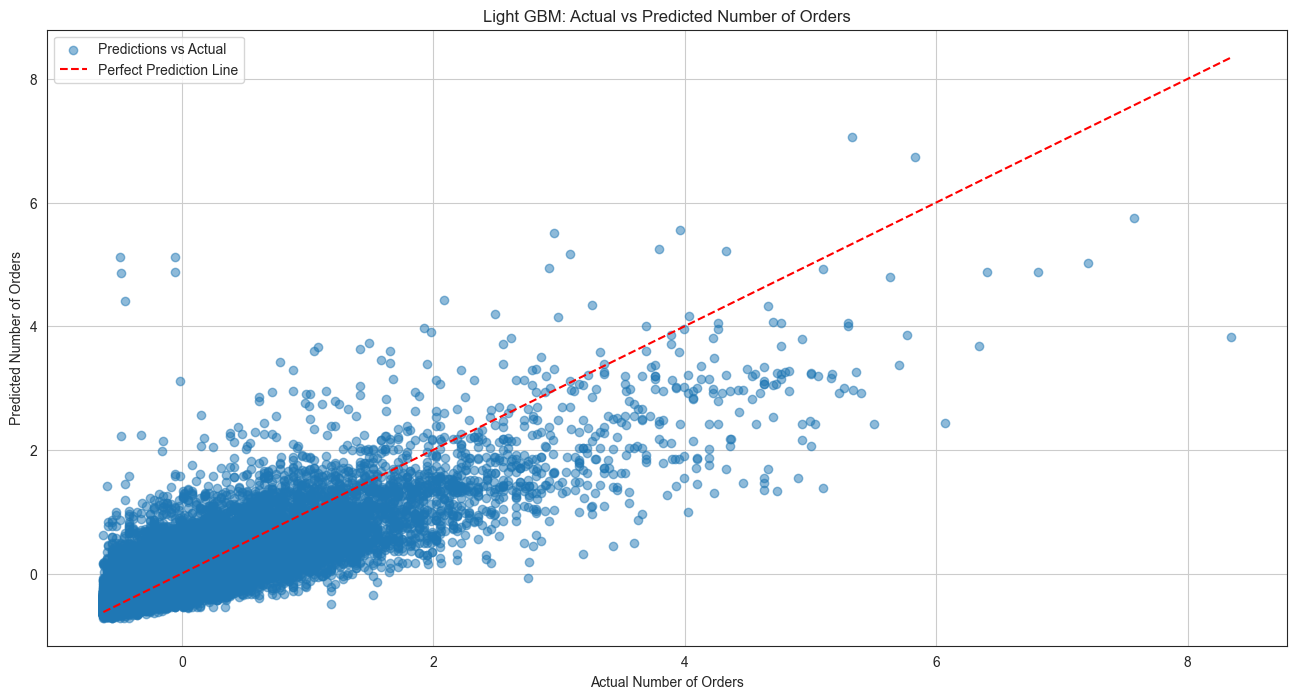

In [339]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, lgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Light GBM: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# model 7: Cat boost

In [340]:
import catboost as cb

In [341]:
cb_regressor = cb.CatBoostRegressor(iterations=100,learning_rate=0.1,depth=6,loss_function='RMSE')

In [342]:
cb_regressor.fit(X_train, y_train)

0:	learn: 0.9535198	total: 178ms	remaining: 17.6s
1:	learn: 0.9139500	total: 205ms	remaining: 10.1s
2:	learn: 0.8815822	total: 235ms	remaining: 7.59s
3:	learn: 0.8509277	total: 264ms	remaining: 6.34s
4:	learn: 0.8264768	total: 293ms	remaining: 5.57s
5:	learn: 0.8041093	total: 324ms	remaining: 5.07s
6:	learn: 0.7822480	total: 353ms	remaining: 4.68s
7:	learn: 0.7640393	total: 381ms	remaining: 4.38s
8:	learn: 0.7471735	total: 410ms	remaining: 4.15s
9:	learn: 0.7339594	total: 438ms	remaining: 3.94s
10:	learn: 0.7208130	total: 466ms	remaining: 3.77s
11:	learn: 0.7103904	total: 495ms	remaining: 3.63s
12:	learn: 0.6991856	total: 522ms	remaining: 3.5s
13:	learn: 0.6887517	total: 551ms	remaining: 3.38s
14:	learn: 0.6805266	total: 580ms	remaining: 3.29s
15:	learn: 0.6716435	total: 608ms	remaining: 3.19s
16:	learn: 0.6641627	total: 636ms	remaining: 3.11s
17:	learn: 0.6564518	total: 665ms	remaining: 3.03s
18:	learn: 0.6499878	total: 692ms	remaining: 2.95s
19:	learn: 0.6447234	total: 721ms	remainin

In [343]:
cb_predictions = cb_regressor.predict(X_test)

In [344]:
mse = metrics.mean_squared_error(y_test, cb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, cb_predictions))
r2 = metrics.r2_score(y_test, cb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 0.18375496312839262
Mse: 0.1515919723581797
Rmse:  0.38934813773559995
R2: 0.6772732499377365


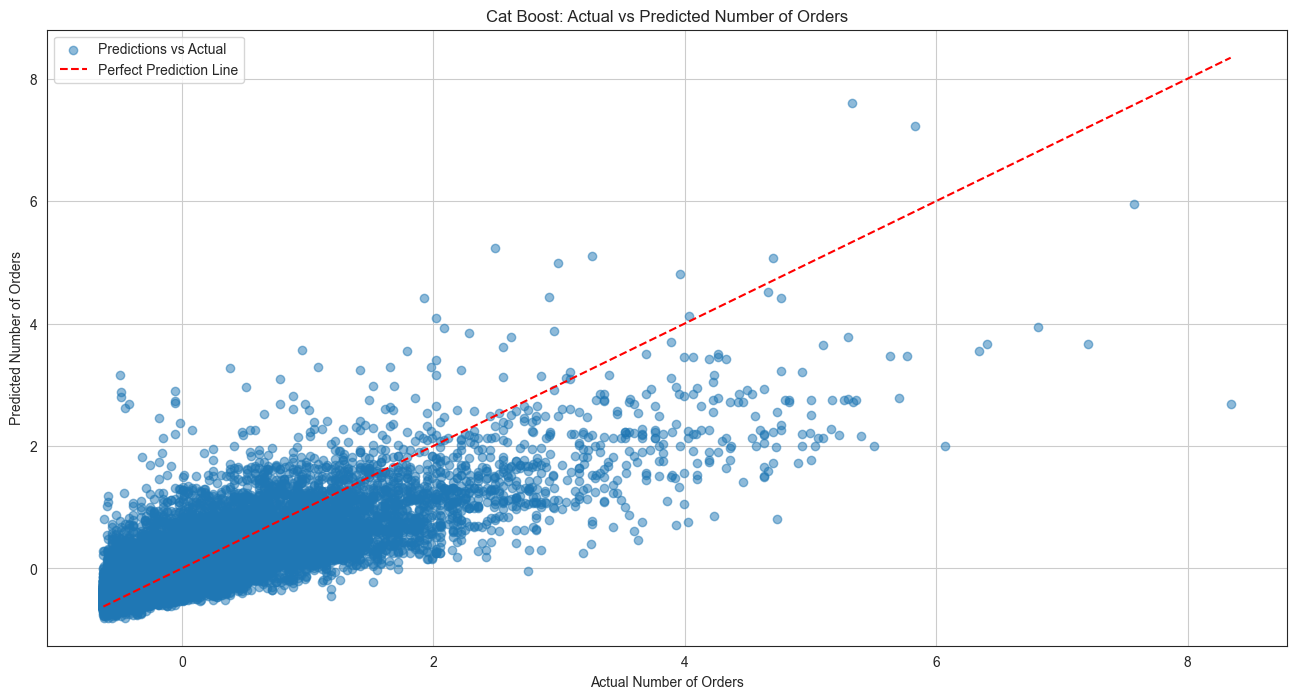

In [345]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, cb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Cat Boost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

Since randon forest regressor gave the best result i.e low Rmse and high R sqaure value. Hence, randon forest regressor will be used to make submision for the Analytics Vidhya Food DEmand Prediction hackathon.

In [347]:
last_10week_predictions_rfr = rfr.predict(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))

In [365]:
last_10week_predictions_xgb = xgb_regressor.predict(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))

In [366]:
last_10week_predictions_xgb

array([-0.36160827, -0.5337541 , -0.67370915, ...,  0.00806893,
        0.03571531, -0.28955197], dtype=float32)

In [367]:
Result=pd.DataFrame(last_10week_predictions_xgb)
# Result=np.expm1(Result).astype('int64')
Submission = pd.DataFrame(columns=['id', 'num_orders'])
Submission['id'] = data[data['week'].isin(range(146,156))]['id']
Submission['num_orders'] = Result.values
Submission.to_csv('Result XGB .csv', index=False)

In [363]:
Submission

,id,num_orders
456548,1028232,0
456549,1127204,0
456550,1212707,0
456551,1082698,0
456552,1400926,0
...,...,...
489116,1250239,0
489117,1039516,0
489118,1158107,0
489119,1444235,0
